In [526]:
import os
import sqlite3
from datetime import datetime
from tqdm import tqdm_notebook

import pandas as pd
import numpy as np
import geopandas as gpd

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import plotly_express as px
import plotly.graph_objects as go

from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from scipy.stats import chi2_contingency
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose


def f_requete_sql (requete) :
    try:
        connexion = sqlite3.connect('./data/liste_piezos.db')
        curseur = connexion.cursor()
        print("Connexion réussie à SQLite")
        curseur.execute(requete)
        connexion.commit()
        resultat = curseur.fetchall()
        curseur.close()
        connexion.close()
        print("Connexion SQLite est fermée")
        return resultat
    except sqlite3.Error as error:
        print("Erreur lors du mis à jour dans la table", error)
        
        
def cmyk_to_rgb(c, m, y, k, cmyk_scale, rgb_scale=255):
    r = rgb_scale * (1.0 - c / float(cmyk_scale)) * (1.0 - k / float(cmyk_scale))
    g = rgb_scale * (1.0 - m / float(cmyk_scale)) * (1.0 - k / float(cmyk_scale))
    b = rgb_scale * (1.0 - y / float(cmyk_scale)) * (1.0 - k / float(cmyk_scale))
    
    if rgb_scale == 255 :      
        return list(map(int, r)), list(map(int, g)), list(map(int, b))
    else :
        return r, g, b
    
    
def sns_to_px (palette) :
    return ['rgb'+ str(color) for color in sns.color_palette("Paired")]

# Chargement des données de clustering piezo

In [2]:
 requete = """
        SELECT code_bss, latitude, longitude, altitude_station, profondeur_investigation, codes_bdlisa, cluster_kmeans, FRANCE_lvl_1, FRANCE_lvl_2, FRANCE_lvl_3, FRANCE_lvl_4, EtatEH, NatureEH, MilieuEH, ThemeEH, OrigineEH
        FROM data_piezo
        INNER JOIN TME
        ON codes_bdlisa = CodeEH
        WHERE cluster_kmeans IS NOT NULL
        """

data_piezo = pd.DataFrame(f_requete_sql(requete))
data_piezo.columns = ["code_bss", "latitude", "longitude", "altitude_station", "profondeur_investigation", "codes_bdlisa", "cluster_kmeans", "FRANCE_lvl_1", "FRANCE_lvl_2", "FRANCE_lvl_3", "FRANCE_lvl_4", "EtatEH", "NatureEH", "MilieuEH", "ThemeEH", "OrigineEH"]
data_piezo.set_index("code_bss", inplace=True)
data_piezo.head()

Connexion réussie à SQLite
Connexion SQLite est fermée


,latitude,longitude,altitude_station,profondeur_investigation,codes_bdlisa,cluster_kmeans,FRANCE_lvl_1,FRANCE_lvl_2,FRANCE_lvl_3,FRANCE_lvl_4,EtatEH,NatureEH,MilieuEH,ThemeEH,OrigineEH
code_bss,,,,,,,,,,,,,,,
03423X0056_100,48.190195,7.396716,174.0,10.7,221AA15,GES_C,FRANCE_3,FRANCE_31,FRANCE_312,FRANCE_3121,2,5,1,1,1
06216X0228_P30-10,46.272865,3.401730,237.2,8.0,932AR01,ARA_A,FRANCE_3,FRANCE_31,FRANCE_312,FRANCE_3122,2,5,1,1,1
09145X0057_N210,44.110203,4.751991,31.0,14.5,712IA01,PAC_A,FRANCE_3,FRANCE_31,FRANCE_313,FRANCE_3131,2,5,1,1,1
06932X0178_P10,45.892458,2.972177,801.8,48.0,153AA01,ARA_A,FRANCE_3,FRANCE_31,FRANCE_312,FRANCE_3122,2,5,4,5,1
06505X0093_PZ10,46.128984,4.761390,175.0,19.0,507AD00,ARA_A,FRANCE_3,FRANCE_31,FRANCE_312,FRANCE_3122,2,7,1,2,3


In [3]:
data_piezo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1193 entries, 03423X0056_100 to 04994X0528_FPZ
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   latitude                  1193 non-null   float64
 1   longitude                 1193 non-null   float64
 2   altitude_station          1193 non-null   float64
 3   profondeur_investigation  1156 non-null   float64
 4   codes_bdlisa              1193 non-null   object 
 5   cluster_kmeans            1193 non-null   object 
 6   FRANCE_lvl_1              1193 non-null   object 
 7   FRANCE_lvl_2              1193 non-null   object 
 8   FRANCE_lvl_3              1193 non-null   object 
 9   FRANCE_lvl_4              1193 non-null   object 
 10  EtatEH                    1193 non-null   object 
 11  NatureEH                  1193 non-null   object 
 12  MilieuEH                  1193 non-null   object 
 13  ThemeEH                   1193 non-null   obj

In [4]:
dict_etat = {"1":"Nappe captive" , 
             "2":"Nappe libre", 
             "3": "Parties libres et captives", 
             "4":"Alternativement libre puis captive"}
dict_nature = {"0":"inconnue",
               "3":"Système aquifère", 
               "5":"Unité aquifère", 
               "6":"Unité semi-perméable",
               "7":"Unité imperméable"}
dict_milieu = {"1":"Poreux", 
               "2":"Sédimentaire", 
               "3": "Karstique", 
               "4":"Matricielle / fissures",
               "5": "Karstique / fissures",
               "6": "Fractures et/ou fissures",
               "8":"Matricielle / karstique",
               "9":"Matrice/fracture/karst"}
dict_theme = {"0":"inconnue",
              "1":"Alluvial", 
              "2":"Sédimentaire", 
              "3":"Matricielle / fissures" , 
              "4":"Intensément plissés de montagne",
              "5":"Volcanisme"}
dict_origine = {"1":"Carte géologique ou hydrogéologique", 
                "2":"Complétude Totale", 
                "3":"Complétude Partielle", 
                "4":"Agrégation par héritage"}

In [5]:
data_piezo.replace({"EtatEH": dict_etat}, inplace=True)
data_piezo.replace({"NatureEH": dict_nature}, inplace=True) 
data_piezo.replace({"MilieuEH": dict_milieu}, inplace=True) 
data_piezo.replace({"ThemeEH": dict_theme}, inplace=True) 

In [6]:
data_piezo.head()

,latitude,longitude,altitude_station,profondeur_investigation,codes_bdlisa,cluster_kmeans,FRANCE_lvl_1,FRANCE_lvl_2,FRANCE_lvl_3,FRANCE_lvl_4,EtatEH,NatureEH,MilieuEH,ThemeEH,OrigineEH
code_bss,,,,,,,,,,,,,,,
03423X0056_100,48.190195,7.396716,174.0,10.7,221AA15,GES_C,FRANCE_3,FRANCE_31,FRANCE_312,FRANCE_3121,Nappe libre,Unité aquifère,Poreux,Alluvial,1
06216X0228_P30-10,46.272865,3.401730,237.2,8.0,932AR01,ARA_A,FRANCE_3,FRANCE_31,FRANCE_312,FRANCE_3122,Nappe libre,Unité aquifère,Poreux,Alluvial,1
09145X0057_N210,44.110203,4.751991,31.0,14.5,712IA01,PAC_A,FRANCE_3,FRANCE_31,FRANCE_313,FRANCE_3131,Nappe libre,Unité aquifère,Poreux,Alluvial,1
06932X0178_P10,45.892458,2.972177,801.8,48.0,153AA01,ARA_A,FRANCE_3,FRANCE_31,FRANCE_312,FRANCE_3122,Nappe libre,Unité aquifère,Matricielle / fissures,Volcanisme,1
06505X0093_PZ10,46.128984,4.761390,175.0,19.0,507AD00,ARA_A,FRANCE_3,FRANCE_31,FRANCE_312,FRANCE_3122,Nappe libre,Unité imperméable,Poreux,Sédimentaire,3


# Chargement de la carte lithologique

In [7]:
URL = 'http://mapsref.brgm.fr/wxs/infoterre/catalogue?SERVICE=WFS&REQUEST=GetFeature&VERSION=2.0.0&TYPENAMES=ms:litho_1M_SIMPLIFIEE'

data_litho = gpd.read_file(URL)

data_litho[["C_FOND", "M_FOND", "J_FOND", "N_FOND"]] = data_litho[["C_FOND", "M_FOND", "J_FOND", "N_FOND"]].astype(int, copy=False)

data_litho["RGB"] = [(tuple(color)) for color in np.stack(cmyk_to_rgb(data_litho.C_FOND, data_litho.M_FOND, data_litho.J_FOND, data_litho.N_FOND, cmyk_scale = 100, rgb_scale=255)).T]

data_litho["RGB_sns"] = [(tuple(color)) for color in np.stack(cmyk_to_rgb(data_litho.C_FOND, data_litho.M_FOND, data_litho.J_FOND, data_litho.N_FOND, cmyk_scale = 100, rgb_scale=1)).T]

data_litho["RGB_str"] = [str(tuple(color)) for color in np.stack(cmyk_to_rgb(data_litho.C_FOND, data_litho.M_FOND, data_litho.J_FOND, data_litho.N_FOND, cmyk_scale = 100, rgb_scale=255)).T]

data_litho["RGB_px"] = ["rgb" + data_litho.loc[line,"RGB_str"] for line in data_litho.index]

data_litho.head()

,gml_id,OBJECTID,CODE_GEOL,SHAPE_Leng,SHAPE_Area,DESCR,TYPE,C_FOND,M_FOND,J_FOND,N_FOND,geometry,RGB,RGB_sns,RGB_str,RGB_px
0,LITHO_1M_SIMPLIFIEE.535,535,8,3042.336690,5.591750e+05,Granites,Roches Magmatiques,0,100,100,0,"POLYGON ((9.25495 41.33883, 9.24708 41.34146, ...","(255, 0, 0)","(1.0, 0.0, 0.0)","(255, 0, 0)","rgb(255, 0, 0)"
1,LITHO_1M_SIMPLIFIEE.536,536,8,5176.176558,1.301260e+06,Granites,Roches Magmatiques,0,100,100,0,"POLYGON ((9.26152 41.36311, 9.25263 41.36788, ...","(255, 0, 0)","(1.0, 0.0, 0.0)","(255, 0, 0)","rgb(255, 0, 0)"
2,LITHO_1M_SIMPLIFIEE.537,537,8,31078.613320,3.406823e+07,Granites,Roches Magmatiques,0,100,100,0,"POLYGON ((9.22235 41.43062, 9.22585 41.42359, ...","(255, 0, 0)","(1.0, 0.0, 0.0)","(255, 0, 0)","rgb(255, 0, 0)"
3,LITHO_1M_SIMPLIFIEE.538,538,6,17541.113318,1.021914e+07,Sables,Roches Sédimentaires,0,0,55,0,"POLYGON ((8.95247 41.49212, 8.94354 41.48919, ...","(255, 255, 114)","(1.0, 1.0, 0.44999999999999996)","(255, 255, 114)","rgb(255, 255, 114)"
4,LITHO_1M_SIMPLIFIEE.539,539,8,2494.234014,2.654343e+05,Granites,Roches Magmatiques,0,100,100,0,"POLYGON ((9.36211 41.54371, 9.35909 41.54462, ...","(255, 0, 0)","(1.0, 0.0, 0.0)","(255, 0, 0)","rgb(255, 0, 0)"


In [8]:
data_litho.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1364 entries, 0 to 1363
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   gml_id      1364 non-null   object  
 1   OBJECTID    1364 non-null   int64   
 2   CODE_GEOL   1364 non-null   int64   
 3   SHAPE_Leng  1364 non-null   float64 
 4   SHAPE_Area  1364 non-null   float64 
 5   DESCR       1364 non-null   object  
 6   TYPE        1364 non-null   object  
 7   C_FOND      1364 non-null   int32   
 8   M_FOND      1364 non-null   int32   
 9   J_FOND      1364 non-null   int32   
 10  N_FOND      1364 non-null   int32   
 11  geometry    1364 non-null   geometry
 12  RGB         1364 non-null   object  
 13  RGB_sns     1364 non-null   object  
 14  RGB_str     1364 non-null   object  
 15  RGB_px      1364 non-null   object  
dtypes: float64(2), geometry(1), int32(4), int64(2), object(7)
memory usage: 149.3+ KB


<AxesSubplot:>

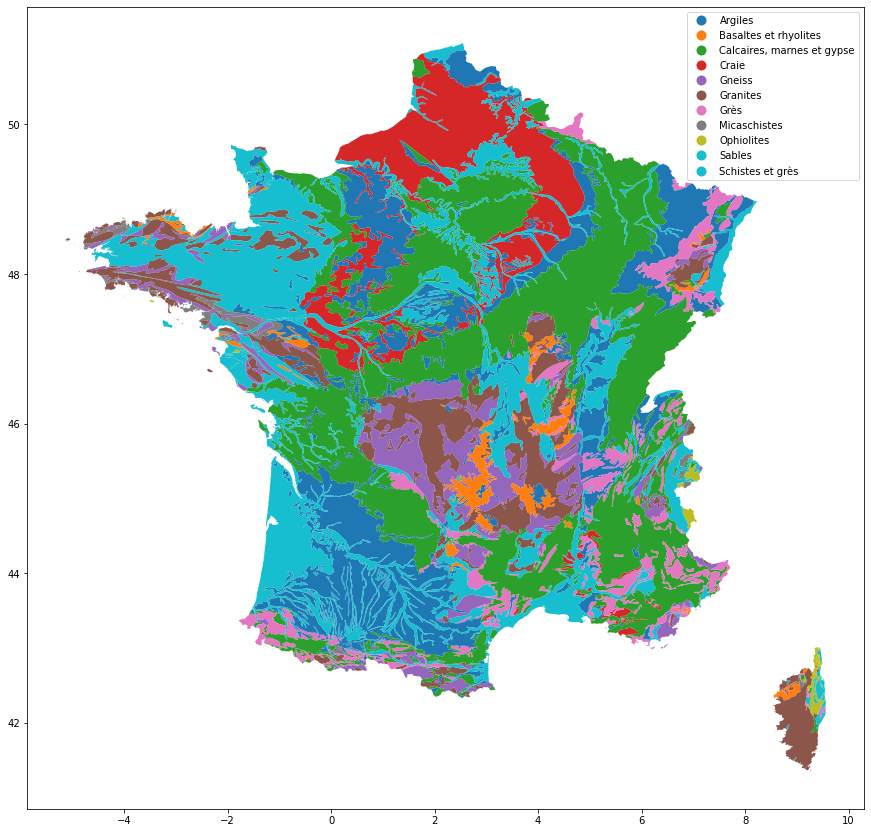

In [9]:
data_litho.plot(figsize=(15,15),
          column = "DESCR",
          legend = True)

# Jointure

## Suppression des lignes NaN dans DESCR

In [10]:
data_piezo = gpd.GeoDataFrame(
    data_piezo, geometry=gpd.points_from_xy(data_piezo.longitude, data_piezo.latitude, crs="CRS84"))
data_piezo.to_crs(crs='EPSG:4326', inplace=True)

data_piezo = gpd.sjoin(data_piezo, data_litho.loc[:,["DESCR", "TYPE", "geometry", "RGB_sns"]], how='left')

data_piezo["dummy_column_for_size"] = 1

index_to_drop= data_piezo[data_piezo['DESCR'].isna()].index
data_piezo.drop(index_to_drop , inplace=True)

data_piezo.head()

,latitude,longitude,altitude_station,profondeur_investigation,codes_bdlisa,cluster_kmeans,FRANCE_lvl_1,FRANCE_lvl_2,FRANCE_lvl_3,FRANCE_lvl_4,...,NatureEH,MilieuEH,ThemeEH,OrigineEH,geometry,index_right,DESCR,TYPE,RGB_sns,dummy_column_for_size
code_bss,,,,,,,,,,,,,,,,,,,,,
03423X0056_100,48.190195,7.396716,174.0,10.7,221AA15,GES_C,FRANCE_3,FRANCE_31,FRANCE_312,FRANCE_3121,...,Unité aquifère,Poreux,Alluvial,1,POINT (7.39672 48.19020),226.0,Argiles,Roches Sédimentaires,"(0.83, 1.0, 0.75)",1
06216X0228_P30-10,46.272865,3.401730,237.2,8.0,932AR01,ARA_A,FRANCE_3,FRANCE_31,FRANCE_312,FRANCE_3122,...,Unité aquifère,Poreux,Alluvial,1,POINT (3.40173 46.27287),1341.0,Sables,Roches Sédimentaires,"(1.0, 1.0, 0.44999999999999996)",1
09145X0057_N210,44.110203,4.751991,31.0,14.5,712IA01,PAC_A,FRANCE_3,FRANCE_31,FRANCE_313,FRANCE_3131,...,Unité aquifère,Poreux,Alluvial,1,POINT (4.75199 44.11020),1064.0,Sables,Roches Sédimentaires,"(1.0, 1.0, 0.44999999999999996)",1
06932X0178_P10,45.892458,2.972177,801.8,48.0,153AA01,ARA_A,FRANCE_3,FRANCE_31,FRANCE_312,FRANCE_3122,...,Unité aquifère,Matricielle / fissures,Volcanisme,1,POINT (2.97218 45.89246),470.0,Basaltes et rhyolites,Roches Magmatiques,"(0.0, 0.30000000000000004, 0.6599999999999999)",1
06505X0093_PZ10,46.128984,4.761390,175.0,19.0,507AD00,ARA_A,FRANCE_3,FRANCE_31,FRANCE_312,FRANCE_3122,...,Unité imperméable,Poreux,Sédimentaire,3,POINT (4.76139 46.12898),402.0,Argiles,Roches Sédimentaires,"(0.83, 1.0, 0.75)",1


In [11]:
data_piezo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1191 entries, 03423X0056_100 to 04994X0528_FPZ
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   latitude                  1191 non-null   float64 
 1   longitude                 1191 non-null   float64 
 2   altitude_station          1191 non-null   float64 
 3   profondeur_investigation  1154 non-null   float64 
 4   codes_bdlisa              1191 non-null   object  
 5   cluster_kmeans            1191 non-null   object  
 6   FRANCE_lvl_1              1191 non-null   object  
 7   FRANCE_lvl_2              1191 non-null   object  
 8   FRANCE_lvl_3              1191 non-null   object  
 9   FRANCE_lvl_4              1191 non-null   object  
 10  EtatEH                    1191 non-null   object  
 11  NatureEH                  1191 non-null   object  
 12  MilieuEH                  1191 non-null   object  
 13  ThemeEH               

# Graphs

## Geoplot

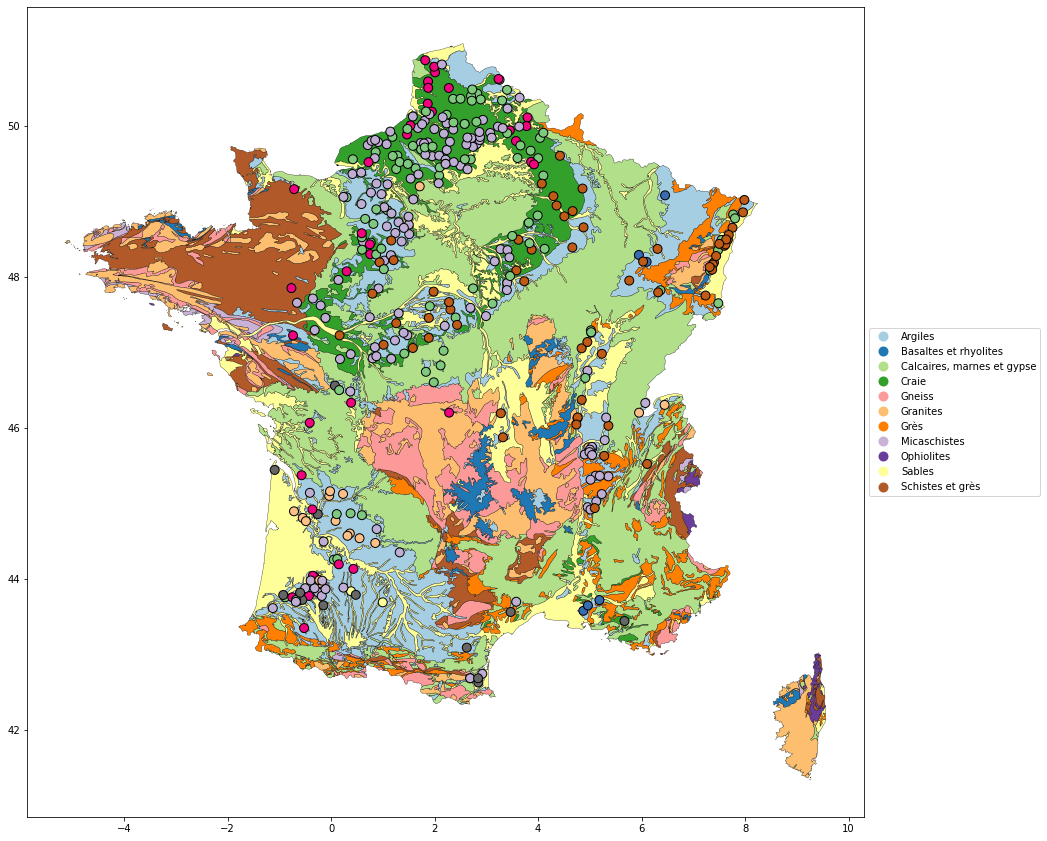

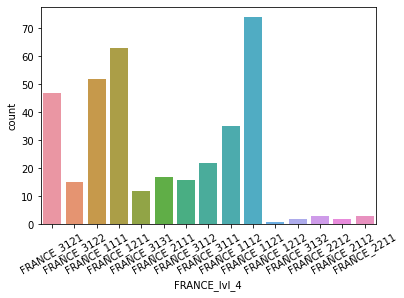

In [12]:
palette = sns.color_palette("Set2")
cmap = ListedColormap(colors=palette)


fig, ax = plt.subplots(figsize=(15,15))

base = data_litho.plot(
            column = data_litho["DESCR"],
            ax = ax,  
            legend = True,
            linewidth=0.3,
            edgecolor='black',
            cmap = "Paired",
            legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5)})

type = ["Argiles", "Craie"]



clusters = data_piezo.loc[data_piezo["DESCR"].isin(type)].plot(column="FRANCE_lvl_4",
            ax=ax, markersize=80, edgecolors="k", legend=False, cmap = "Accent")

plt.show()

ax = sns.countplot(x= data_piezo.loc[data_piezo["DESCR"].isin(type), "FRANCE_lvl_4"])
_= ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)

## Plotly Express

### choroplet map box

In [50]:
data_litho.sort_values(by= "DESCR", inplace=True)

#### colors from dataframe

In [ ]:
dict_colors = dict(zip(data_litho.DESCR.unique(), data_litho.RGB_px.unique()))

fig = px.choropleth_mapbox(data_frame = data_litho, 
                     geojson=data_litho["geometry"], 
                     locations = data_litho.index, 
                     color=data_litho["DESCR"],
                     mapbox_style='white-bg',
                     opacity=0.5,
                     labels= {"DESCR" : "Terrain"},
                     center={"lat": 47, "lon": 2.2},
                     category_orders = {"DESCR": sorted(data_litho.DESCR.unique())},
                     color_discrete_map=dict_colors,
                     zoom=4.3)


data_scat = px.scatter_mapbox(data_piezo,
                             lat="latitude",
                             lon="longitude",
                             color="FRANCE_lvl_4",
                             color_discrete_sequence = px.colors.qualitative.Light24,
                             size = "dummy_column_for_size",
                             size_max = 5,
                             hover_name = data_piezo.index,
                             hover_data={'FRANCE_lvl_4':False,
                                         'dummy_column_for_size':False,
                                         'latitude':False,
                                         'longitude':False,
                                         'DESCR': True,
                                         'TYPE': True},
                             labels={"FRANCE_lvl_4" : "Clusters"},
                              category_orders = {"FRANCE_lvl_4": sorted(data_piezo.FRANCE_lvl_4.unique())}
                             ).data
          

for item in range(len(data_scat)):
    fig.add_trace(data_scat[item])
    fig.update_traces(mode="markers", 
                      selector=dict(type='scattermapbox'))
    fig.update_layout(legend= {'itemsizing': 'constant'})

fig.show()

#### Colors from Paired

In [53]:
[color for color in sns.color_palette("Paired")]

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [61]:
palette = sns_to_px(sns.color_palette("Paired"))
del palette[5]

In [ ]:
fig = px.choropleth_mapbox(data_frame = data_litho, 
                     geojson=data_litho["geometry"], 
                     locations = data_litho.index, 
                     color=data_litho["DESCR"],
                     mapbox_style='white-bg',
                     opacity=1,
                     labels= {"DESCR" : "Terrain"},
                     center={"lat": 47, "lon": 2.2},
                     category_orders = {"DESCR": sorted(data_litho.DESCR.unique())},
                     color_discrete_sequence=palette,
                     zoom=4.3)


data_scat = px.scatter_mapbox(data_piezo,
                             lat="latitude",
                             lon="longitude",
                             color="FRANCE_lvl_4",
                             color_discrete_sequence = px.colors.qualitative.Light24,
                             size = "dummy_column_for_size",
                             size_max = 5,
                             hover_name = data_piezo.index,
                             hover_data={'FRANCE_lvl_4':False,
                                         'dummy_column_for_size':False,
                                         'latitude':False,
                                         'longitude':False,
                                         'DESCR': True,
                                         'TYPE': True},
                             labels={"FRANCE_lvl_4" : "Clusters"},
                              category_orders = {"FRANCE_lvl_4": sorted(data_piezo.FRANCE_lvl_4.unique())}
                             ).data
          

for item in range(len(data_scat)):
    fig.add_trace(data_scat[item])
    fig.update_traces(mode="markers", 
                      selector=dict(type='scattermapbox'))
    fig.update_layout(legend= {'itemsizing': 'constant'})

fig.show()

## Countplot

In [ ]:
data_piezo.head()

In [ ]:
# Create an array with the colors you want to use
colors = data_litho[["DESCR","RGB_sns"]].drop_duplicates().sort_values(by="DESCR")["RGB_sns"].values
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))

In [ ]:
type_terrain = "Argiles"
cluster = "FRANCE_3131"

colors = data_piezo.loc[data_piezo.FRANCE_lvl_4 == cluster,["DESCR","RGB_sns"]].drop_duplicates().sort_values(by="DESCR")["RGB_sns"].values
customPalette = sns.set_palette(sns.color_palette(colors))

In [ ]:
type_terrain = "Craie"
cluster = "FRANCE_3131"
donnees = data_piezo.loc[data_piezo.FRANCE_lvl_4 == cluster]
ax = sns.countplot(data=donnees, x="DESCR", palette=px.colors.qualitative.Light24)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
ax.set_xticklabels
_=plt.show()

## Analyse via crosstab

In [ ]:
donnees_cluster = pd.crosstab(data_piezo["FRANCE_lvl_3"], data_piezo["DESCR"], margins=True, margins_name="total", normalize = 'index')
donnees_cluster

In [ ]:
customPalette = sns.set_palette(sns.color_palette(colors))

In [ ]:
g_cluster = sns.barplot(x="Granites", y=donnees_cluster.index,
                data=donnees_cluster,
                palette = customPalette,
                saturation=.5)

In [ ]:
donnees_terrain = pd.crosstab(data_piezo["DESCR"], data_piezo["FRANCE_lvl_3"],  normalize='index')
donnees_terrain

In [ ]:
# Create an array with the colors you want to use
colors = data_litho[["DESCR","RGB_sns"]].drop_duplicates().sort_values(by="DESCR")["RGB_sns"].values
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))

In [ ]:
customPalette

In [ ]:
g_terrain = sns.barplot(x="FRANCE_311", y=donnees_terrain.index,
                data=donnees_terrain,
                palette=customPalette,
                saturation=.5)

g_terrain.set_xlim(right=1)
g_terrain.set_xlabel('')
g_terrain.set_ylabel('')

## Fonction Streamlit

In [ ]:
def f_count_plot(data_piezo, data_litho, filtre, valeur, cluster_level):
    # Create an array with the colors you want to use
    

    fig, ax = plt.subplots()
    
    if filtre == "Terrain" :
        
        donnees_cluster = pd.crosstab(data_piezo["FRANCE_lvl_3"], data_piezo["DESCR"], normalize='index')
        ax = sns.barplot(x=valeur, y=donnees_cluster.index,
                data=donnees_cluster, 
                saturation=.5)

        ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
        ax.set_ylabel('')
        ax.set_xlabel('Clusters')

    if filtre == "Cluster" :
        
        donnees_terrain = pd.crosstab(data_piezo["DESCR"], data_piezo[cluster_level],  normalize='index')
        colors = data_piezo.loc[data_piezo[cluster_level] == valeur,["DESCR","RGB_sns"]].drop_duplicates().sort_values(by="DESCR")["RGB_sns"].values
        # Set your custom color palette
        customPalette = sns.set_palette(sns.color_palette(colors))

        ax = sns.barplot(x=valeur, y=donnees_terrain.index,
                        palette = customPalette,
                        data=donnees_terrain,
                        order = sorted(donnees_terrain.index.drop_duplicates().values))
        ax.set_xlabel('')
        ax.set_ylabel('')

# Affichage Chronique

## All piezo

In [ ]:
level = "FRANCE_lvl_2"
clusters = ["21", '31', "11", "12"]
palette = px.colors.qualitative.Light24

fig = go.Figure()

for index, cluster in enumerate(clusters) :
    custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")
    chroniques = pd.read_csv(f"./Clustering/data/FRANCE.csv", sep = ";", parse_dates=True, index_col="date_mesure", date_parser=custom_date_parser)

    requete = f"""
            SELECT code_bss
            FROM cluster_list
            WHERE {level} = {cluster}
            """

    list_chroniques = np.stack(pd.DataFrame(f_requete_sql(requete)).values.T)[0].tolist()

    # plot piezos
    fig_all = px.line(chroniques[list_chroniques], title='Evolution temporelle standardisée des chroniques')
    fig_all.update_traces(line=dict(width=1, color = palette[index]), opacity = 0.4)
    fig_all.update_layout(showlegend=False)
    
    # plot moyenne du cluster
    fig_mean = px.line(chroniques[list_chroniques].mean(axis=1))
    fig_mean.data[0].name = cluster
    fig_mean.update_traces(line=dict(width=2, color = palette[index]), opacity = 1)
    
    fig.add_trace(fig_mean.data[0])
    fig.add_traces(fig_all.data)
    
    fig_all.update_layout(legend_title="Chroniques")

    
for trace in range(len(fig['data'])):
    if len(fig['data'][trace]['name']) > 4:
        fig['data'][trace]['showlegend'] = False
    else :
        fig['data'][trace]['showlegend'] = True
fig

## Only mean

In [ ]:
level = "FRANCE_lvl_2"
clusters = ["21", '31', "11", "12"]


requete = f"""
        SELECT code_bss
        FROM cluster_list
        WHERE {level} = {clusters[0]}
        """
list_chroniques = np.stack(pd.DataFrame(f_requete_sql(requete)).values.T)[0].tolist()

custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")
chroniques = pd.read_csv(f"./Clustering/data/FRANCE.csv", sep = ";", parse_dates=True, index_col="date_mesure", date_parser=custom_date_parser)

df_clusters = pd.DataFrame()
df_clusters[clusters[0]] = chroniques[list_chroniques].mean(axis=1)

for index, cluster in enumerate(clusters) :
    if index > 0 :
        requete = f"""
            SELECT code_bss
            FROM cluster_list
            WHERE {level} = {cluster}
            """
        list_chroniques = np.stack(pd.DataFrame(f_requete_sql(requete)).values.T)[0].tolist()

        custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")
        chroniques = pd.read_csv(f"./Clustering/data/FRANCE.csv", sep = ";", parse_dates=True, index_col="date_mesure", date_parser=custom_date_parser)

        df_clusters[cluster] = chroniques[list_chroniques].mean(axis=1)

In [ ]:
px.line(df_clusters)

In [ ]:
st_cluster_level = 3

dict_cluster_levels = {1: "FRANCE_lvl_1",
                    2: "FRANCE_lvl_2",
                    3: "FRANCE_lvl_3",
                    4: "FRANCE_lvl_4"}

cluster_level = dict_cluster_levels[st_cluster_level]


def f_chroniques(cluster_level) :
    # Liste des clusters
    requete = f"""
                SELECT DISTINCT {cluster_level}
                FROM cluster_list
                """
    clusters = [item[0] for item in f_requete_sql(requete)]

    # Liste des chroniques pour 1er cluster
    requete = f"""
            SELECT code_bss
            FROM cluster_list
            WHERE {cluster_level} = {clusters[0]}
            """
    list_chroniques = [item[0] for item in f_requete_sql(requete)]

    custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")
    chroniques = pd.read_csv(f"./Clustering/data/FRANCE.csv", sep = ";", parse_dates=True, index_col="date_mesure", date_parser=custom_date_parser)

    df_clusters = pd.DataFrame()
    df_clusters[clusters[0]] = chroniques[list_chroniques].mean(axis=1)

    for index, cluster in enumerate(clusters) :
        if index > 0 :
            requete = f"""
            SELECT code_bss
            FROM cluster_list
            WHERE {cluster_level} = {cluster}
                """
            list_chroniques = [item[0] for item in f_requete_sql(requete)]

            custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")
            chroniques = pd.read_csv(f"./Clustering/data/FRANCE.csv", sep = ";", parse_dates=True, index_col="date_mesure", date_parser=custom_date_parser)

            df_clusters[cluster] = chroniques[list_chroniques].mean(axis=1)
    
    figure = px.line(df_clusters, color_discrete_sequence = px.colors.qualitative.Light24)
    figure.update_layout(legend_title="")
    return figure

f_chroniques(cluster_level)



## PX GO

In [ ]:
fig = go.Figure()


fig.add_trace(go.Choroplethmapbox(data_frame = litho, 
                     geojson=litho["geometry"], 
                     locations = litho.index, 
                     color=litho["DESCR"],
                     mapbox_style='carto-positron',
                     color_discrete_map=dict_colors,
                     opacity=0.5,
                     labels= {"DESCR" : "Terrain"},
                     center={"lat": 47, "lon": 2.2},
                     zoom=4.3))


fig.add_trace(go.Scattermapbox(data,
                             lat="latitude",
                             lon="longitude",
                             color="FRANCE_lvl_4",
                             size = "dummy_column_for_size",
                             size_max = 5,
                             labels={"FRANCE_lvl_4" : "Clusters"}).data)


fig.show()

# Essais Folium

In [ ]:
%matplotlib inline
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import folium
from folium import IFrame
from geopy.geocoders import Nominatim

In [ ]:
litho.plot()

In [ ]:
m = folium.Map([47, 2], zoom_start=7)

ft = "DESCR" 
cmap = folium.colormap.linear.YlOrRd.scale(geo_merge[ft].min(), geo_merge[ft].max()) 



folium.TileLayer('OpenStreetMap').add_to(m)
folium.GeoJson(litho,
               style_function=lambda feature: {
                   'fillOpacity' : 0.5,
                   'columns' : "DESCR",
                   'key_on' : 'litho.RGB',
                   'weight' : 1, 
                   'color' : 'black'
               }).add_to(m)
m

In [ ]:
palette = sns.color_palette("Set2")
cmap = ListedColormap(colors=palette)

carte = folium.Map([47, 2], zoom_start=7)

folium.Choropleth(
    geo_data = litho.to_json(),                  #json
    name ='choropleth',                  
    data = litho,
    key_on='OBJECTID',
    columns = ['gml_id', 'DESCR'], #columns to work on
    fill_color = 'YlGnBu',     #I passed colors Yellow,Green,Blue
    fill_opacity = 0.5,
    line_opacity = 0.2,
    nan_fill_color="purple",
    legend_name = "LEGENDE"
).add_to(carte)
carte

In [ ]:
litho.columns

In [ ]:
import folium
new_york = folium.Map(location=[40.7128,-73.9352])
new_york

In [ ]:
folium.Map(
    location=[40.7128,-73.9352],
    tiles='Stamen Toner',
    zoom_start=13
)

In [ ]:
folium.Map?

# Analyses

In [172]:
data_piezo.head()

,latitude,longitude,altitude_station,profondeur_investigation,codes_bdlisa,cluster_kmeans,FRANCE_lvl_1,FRANCE_lvl_2,FRANCE_lvl_3,FRANCE_lvl_4,...,NatureEH,MilieuEH,ThemeEH,OrigineEH,geometry,index_right,DESCR,TYPE,RGB_sns,dummy_column_for_size
code_bss,,,,,,,,,,,,,,,,,,,,,
03423X0056_100,48.190195,7.396716,174.0,10.7,221AA15,GES_C,FRANCE_3,FRANCE_31,FRANCE_312,FRANCE_3121,...,Unité aquifère,Poreux,Alluvial,1,POINT (7.39672 48.19020),226.0,Argiles,Roches Sédimentaires,"(0.83, 1.0, 0.75)",1
06216X0228_P30-10,46.272865,3.401730,237.2,8.0,932AR01,ARA_A,FRANCE_3,FRANCE_31,FRANCE_312,FRANCE_3122,...,Unité aquifère,Poreux,Alluvial,1,POINT (3.40173 46.27287),1341.0,Sables,Roches Sédimentaires,"(1.0, 1.0, 0.44999999999999996)",1
09145X0057_N210,44.110203,4.751991,31.0,14.5,712IA01,PAC_A,FRANCE_3,FRANCE_31,FRANCE_313,FRANCE_3131,...,Unité aquifère,Poreux,Alluvial,1,POINT (4.75199 44.11020),1064.0,Sables,Roches Sédimentaires,"(1.0, 1.0, 0.44999999999999996)",1
06932X0178_P10,45.892458,2.972177,801.8,48.0,153AA01,ARA_A,FRANCE_3,FRANCE_31,FRANCE_312,FRANCE_3122,...,Unité aquifère,Matricielle / fissures,Volcanisme,1,POINT (2.97218 45.89246),470.0,Basaltes et rhyolites,Roches Magmatiques,"(0.0, 0.30000000000000004, 0.6599999999999999)",1
06505X0093_PZ10,46.128984,4.761390,175.0,19.0,507AD00,ARA_A,FRANCE_3,FRANCE_31,FRANCE_312,FRANCE_3122,...,Unité imperméable,Poreux,Sédimentaire,3,POINT (4.76139 46.12898),402.0,Argiles,Roches Sédimentaires,"(0.83, 1.0, 0.75)",1


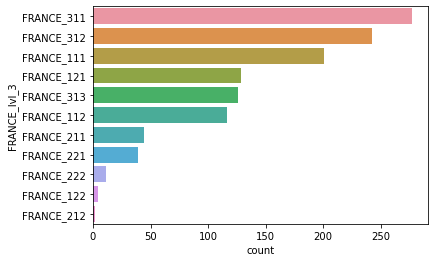

In [173]:
sns.countplot(data = data_piezo, y= "FRANCE_lvl_3", order = data_piezo['FRANCE_lvl_3'].value_counts().index)
_= plt.show()

In [290]:
data_piezo_data = data_piezo.drop(["latitude", "longitude", "cluster_kmeans", "index_right", "RGB_sns", "OrigineEH", "geometry", "dummy_column_for_size"], axis=1)
data_piezo_data = data_piezo_data.loc[(data_piezo_data["EtatEH"] != 'X') & (data_piezo_data["MilieuEH"] != 'X')]

In [291]:
data_piezo_bdlisa = data_piezo[["codes_bdlisa", "FRANCE_lvl_4"]]

## Analyse BDLISA

In [254]:
cross = pd.crosstab(data_piezo_bdlisa["codes_bdlisa"], data_piezo_bdlisa["FRANCE_lvl_4"], normalize='index')

<AxesSubplot:xlabel='FRANCE_lvl_4', ylabel='codes_bdlisa'>

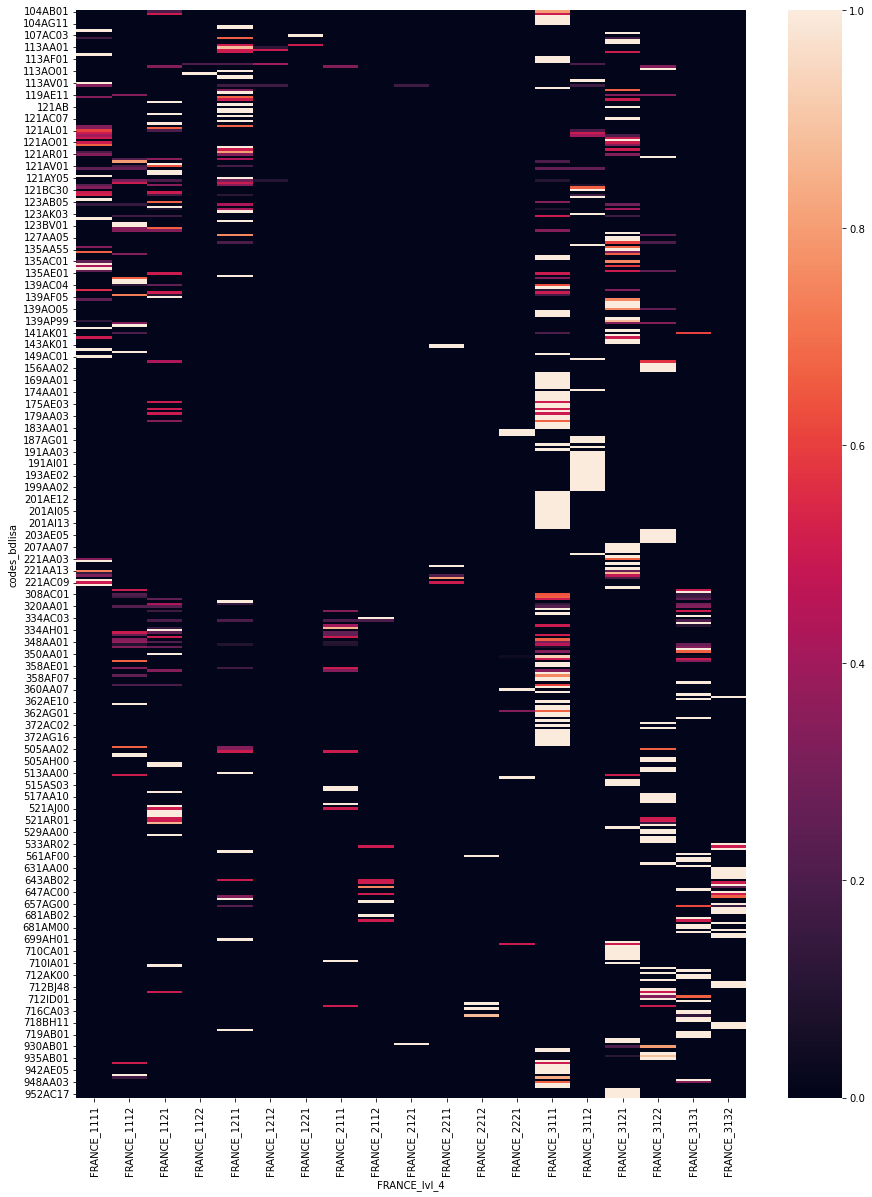

In [255]:
fig = plt.figure(figsize=(15,20))
sns.heatmap(cross)

## Anlyse données terrain

### chi2 - ordre 2

In [574]:
cluster_level = "FRANCE_lvl_3"

In [575]:
data_piezo_data.head()

,altitude_station,profondeur_investigation,codes_bdlisa,FRANCE_lvl_1,FRANCE_lvl_2,FRANCE_lvl_3,FRANCE_lvl_4,EtatEH,NatureEH,MilieuEH,ThemeEH,DESCR,TYPE
code_bss,,,,,,,,,,,,,
03423X0056_100,174.0,10.7,221AA15,FRANCE_3,FRANCE_31,FRANCE_312,FRANCE_3121,Nappe libre,Unité aquifère,Poreux,Alluvial,Argiles,Roches Sédimentaires
06216X0228_P30-10,237.2,8.0,932AR01,FRANCE_3,FRANCE_31,FRANCE_312,FRANCE_3122,Nappe libre,Unité aquifère,Poreux,Alluvial,Sables,Roches Sédimentaires
09145X0057_N210,31.0,14.5,712IA01,FRANCE_3,FRANCE_31,FRANCE_313,FRANCE_3131,Nappe libre,Unité aquifère,Poreux,Alluvial,Sables,Roches Sédimentaires
06932X0178_P10,801.8,48.0,153AA01,FRANCE_3,FRANCE_31,FRANCE_312,FRANCE_3122,Nappe libre,Unité aquifère,Matricielle / fissures,Volcanisme,Basaltes et rhyolites,Roches Magmatiques
06505X0093_PZ10,175.0,19.0,507AD00,FRANCE_3,FRANCE_31,FRANCE_312,FRANCE_3122,Nappe libre,Unité imperméable,Poreux,Sédimentaire,Argiles,Roches Sédimentaires


In [581]:
crosstab = pd.crosstab(data_piezo_data["FRANCE_lvl_4"],
                       columns=[data_piezo_data["EtatEH"], data_piezo_data["ThemeEH"]],
                       normalize='columns')
crosstab

EtatEH       Alternativement libre puis captive          Nappe captive  \
ThemeEH                            Sédimentaire Matricielle / fissures   
FRANCE_lvl_4                                                             
FRANCE_1111                            0.000000                    1.0   
FRANCE_1112                            0.111111                    0.0   
FRANCE_1121                            0.000000                    0.0   
FRANCE_1122                            0.000000                    0.0   
FRANCE_1211                            0.000000                    0.0   
FRANCE_1212                            0.000000                    0.0   
FRANCE_1221                            0.000000                    0.0   
FRANCE_2111                            0.000000                    0.0   
FRANCE_2112                            0.000000                    0.0   
FRANCE_2121                            0.000000                    0.0   
FRANCE_2211                            0.000000                    0.0   
FRANCE_2212                            0.000000                    0.0   
FRANCE_2221                            0.000000                    0.0   
FRANCE_3111                            0.777778                    0.0   
FRANCE_3112                            0.000000                    0.0   
FRANCE_3121                            0.000000                    0.0   
FRANCE_3122                            0.000000                    0.0   
FRANCE_3131                            0.000000                    0.0   
FRANCE_3132                            0.111111                    0.0   

EtatEH                    Nappe libre                                  \
ThemeEH      Sédimentaire    Alluvial Intensément plissés de montagne   
FRANCE_lvl_4                                                            
FRANCE_1111      0.044199    0.185022                        0.000000   
FRANCE_1112      0.149171    0.000000                        0.000000   
FRANCE_1121      0.121547    0.008811                        0.000000   
FRANCE_1122      0.000000    0.000000                        0.000000   
FRANCE_1211      0.071823    0.004405                        0.000000   
FRANCE_1212      0.000000    0.000000                        0.000000   
FRANCE_1221      0.000000    0.000000                        0.000000   
FRANCE_2111      0.127072    0.008811                        0.000000   
FRANCE_2112      0.016575    0.000000                        0.222222   
FRANCE_2121      0.000000    0.004405                        0.000000   
FRANCE_2211      0.000000    0.101322                        0.000000   
FRANCE_2212      0.000000    0.048458                        0.000000   
FRANCE_2221      0.000000    0.004405                        0.000000   
FRANCE_3111      0.182320    0.039648                        0.000000   
FRANCE_3112      0.005525    0.000000                        0.000000   
FRANCE_3121      0.038674    0.325991                        0.000000   
FRANCE_3122      0.049724    0.136564                        0.111111   
FRANCE_3131      0.182320    0.088106                        0.444444   
FRANCE_3132      0.011050    0.044053                        0.222222   

EtatEH                                                       \
ThemeEH      Matricielle / fissures Sédimentaire Volcanisme   
FRANCE_lvl_4                                                  
FRANCE_1111                0.000000     0.121495   0.000000   
FRANCE_1112                0.000000     0.096573   0.000000   
FRANCE_1121                0.035398     0.177570   0.272727   
FRANCE_1122                0.000000     0.000000   0.000000   
FRANCE_1211                0.008850     0.130841   0.000000   
FRANCE_1212                0.000000     0.006231   0.000000   
FRANCE_1221                0.000000     0.000000   0.000000   
FRANCE_2111                0.000000     0.006231   0.000000   
FRANCE_2112                0.000000     0.009346   0.000000   
FRANCE_2

<AxesSubplot:xlabel='EtatEH-ThemeEH', ylabel='FRANCE_lvl_4'>

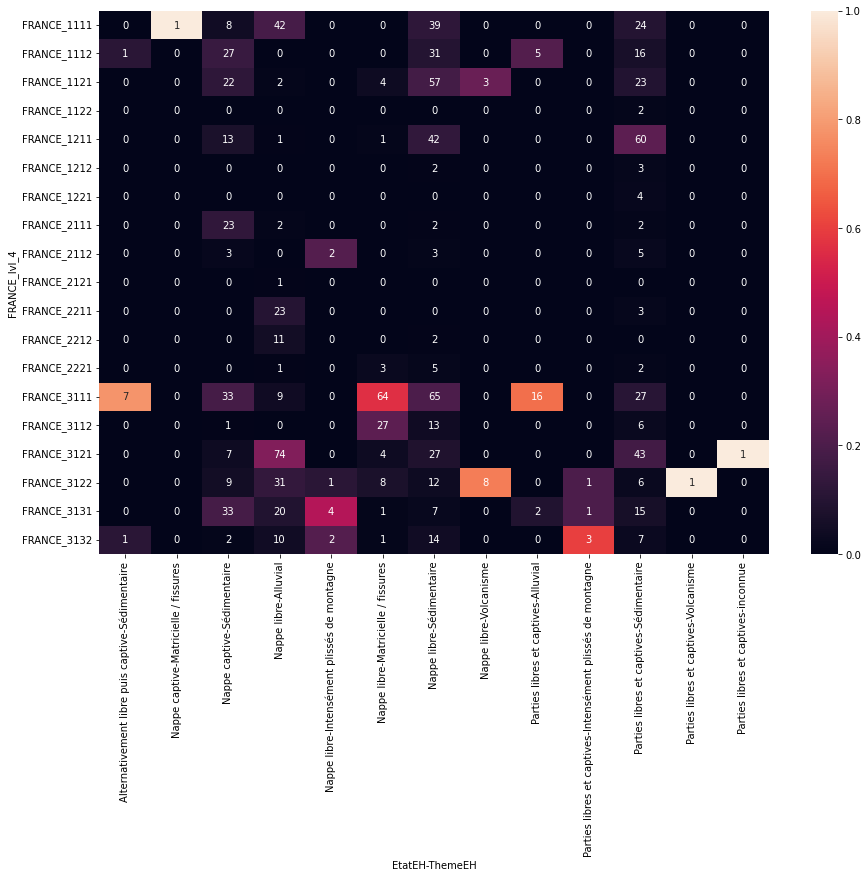

In [584]:
plt.figure(figsize=(15,10))
sns.heatmap(crosstab, annot=pd.crosstab(data_piezo_data["FRANCE_lvl_4"],
                       columns=[data_piezo_data["EtatEH"], data_piezo_data["ThemeEH"]]))


In [530]:
chi2_contingency(crosstab)

(186.48091865798276,
 8.73150446235043e-21,
 40,
 array([[5.06086957e-01, 1.68695652e+02, 3.03652174e+00, 2.15930435e+01,
         1.68695652e-01],
        [2.94782609e-01, 9.82608696e+01, 1.76869565e+00, 1.25773913e+01,
         9.82608696e-02],
        [3.18260870e-01, 1.06086957e+02, 1.90956522e+00, 1.35791304e+01,
         1.06086957e-01],
        [1.04347826e-02, 3.47826087e+00, 6.26086957e-02, 4.45217391e-01,
         3.47826087e-03],
        [1.09565217e-01, 3.65217391e+01, 6.57391304e-01, 4.67478261e+00,
         3.65217391e-02],
        [2.60869565e-03, 8.69565217e-01, 1.56521739e-02, 1.11304348e-01,
         8.69565217e-04],
        [1.01739130e-01, 3.39130435e+01, 6.10434783e-01, 4.34086957e+00,
         3.39130435e-02],
        [2.86956522e-02, 9.56521739e+00, 1.72173913e-01, 1.22434783e+00,
         9.56521739e-03],
        [6.99130435e-01, 2.33043478e+02, 4.19478261e+00, 2.98295652e+01,
         2.33043478e-01],
        [6.07826087e-01, 2.02608696e+02, 3.64695652e+00, 2.5

In [519]:
cross = pd.crosstab(data_piezo_data[cluster_level], columns=[data_piezo_data["EtatEH"], 
                                                     data_piezo_data["MilieuEH"],
                                                     data_piezo_data["DESCR"]],
           normalize='columns')
cross

EtatEH       Alternativement libre puis captive                             \
MilieuEH                   Karstique / fissures                     Poreux   
DESCR                Calcaires, marnes et gypse Calcaires, marnes et gypse   
FRANCE_lvl_2                                                                 
FRANCE_11                                 0.125                        0.0   
FRANCE_12                                 0.000                        0.0   
FRANCE_21                                 0.000                        0.0   
FRANCE_22                                 0.000                        0.0   
FRANCE_31                                 0.875                        1.0   

EtatEH              Nappe captive                                       \
MilieuEH     Karstique / fissures                                        
DESCR                     Argiles Calcaires, marnes et gypse    Sables   
FRANCE_lvl_2                                                             
FRANCE_11                    0.50                        0.5  0.000000   
FRANCE_12                    0.25                        0.0  0.000000   
FRANCE_21                    0.00                        0.0  0.571429   
FRANCE_22                    0.00                        0.0  0.000000   
FRANCE_31                    0.25                        0.5  0.428571   

EtatEH                                                                 \
MilieuEH     Matricielle / fissures                                     
DESCR                       Argiles Calcaires, marnes et gypse Sables   
FRANCE_lvl_2                                                            
FRANCE_11                      0.50                   0.500000    0.1   
FRANCE_12                      0.05                   0.083333    0.0   
FRANCE_21                      0.15                   0.000000    0.2   
FRANCE_22                      0.00                   0.000000    0.0   
FRANCE_31                      0.30                   0.416667    0.7   

EtatEH                                                           ...  \
MilieuEH     Matricielle / karstique                             ...   
DESCR                        Argiles Calcaires, marnes et gypse  ...   
FRANCE_lvl_2                                                     ...   
FRANCE_11                      0.250                       0.44  ...   
FRANCE_12                      0.000                       0.04  ...   
FRANCE_21                      0.625                       0.00  ...   
FRANCE_22                      0.000                       0.00  ...   
FRANCE_31                      0.125                       0.52  ...   

EtatEH       Parties libres et captives                                  \
MilieuEH                         Poreux                                   
DESCR        Calcaires, marnes et gypse     Craie Gneiss Grès    Sables   
FRANCE_lvl_2                                                              
FRANCE_11                      0.038462  0.333333    1.0  0.8  0.095238   
FRANCE_12                      0.269231  0.555556    0.0  0.0  0.095238   
FRANCE_21                      0.000000  0.000000    0.0  0.2  0.071429   
FRANCE_22                      0.038462  0.000000    0.0  0.0  0.023810   
FRANCE_31                      0.653846  0.111111    0.0  0.0  0.714286   

EtatEH                                                                       \
MilieuEH                      Sédimentaire                                    
DESCR        Schistes et grès      Argiles Calcaires, marnes et gypse Craie   
FRANCE_lvl_2                                                                  
FRANCE_11                 0.0         0.50                        0.2  0.75   
FRANCE_12                 0.0         0.25                        0.0  0.00   
FRANCE_21                 0.0         0.00                        0.0  0.00   
FRANCE_22                 0.0         0.00                        0.0  0.00   
FRANCE_31      

In [500]:
# Création d'un dictionnaire pour lier combinaison de terrain avec numéro de colonne
# Pas de solution pour utiliser loc avec nom de colonne composé
dict_from_list = dict(zip(cross.columns, range(len(cross.columns))))

### Plot clusters vs Terrains

In [563]:
filt_EtatEH = "Nappe captive"
filt_MilieuEH = "Poreux"
filt_DESCR = "Calcaires, marnes et gypse"
fil_total = filt_EtatEH, filt_MilieuEH, filt_DESCR


num_colonne = dict_from_list[fil_total]
tab_donnees = pd.DataFrame()
tab_donnees.index = cross.index
tab_donnees["Terrain_1"] = pd.Series(cross.iloc[:,num_colonne])

filt_EtatEH_2 = "Nappe captive"
filt_MilieuEH_2 = "Poreux"
filt_DESCR_2 = "Sables"
fil_total_2 = filt_EtatEH_2, filt_MilieuEH_2, filt_DESCR_2

num_colonne = dict_from_list[fil_total_2]
tab_donnees["Terrain_2"] = pd.Series(cross.iloc[:,num_colonne])
tab_donnees = tab_donnees.reset_index()
tab_donnees

,FRANCE_lvl_2,Terrain_1,Terrain_2
0,FRANCE_11,0.75,0.20
1,FRANCE_12,0.00,0.08
2,FRANCE_21,0.00,0.08
3,FRANCE_22,0.00,0.00
4,FRANCE_31,0.25,0.64


In [565]:
tab_donnees_g = tab_donnees.reset_index()
tab_donnees_g = pd.melt(tab_donnees, id_vars='FRANCE_lvl_2', value_vars=['Terrain_1', 'Terrain_2'])
tab_donnees_g

,FRANCE_lvl_2,variable,value
0,FRANCE_11,Terrain_1,0.75
1,FRANCE_12,Terrain_1,0.00
2,FRANCE_21,Terrain_1,0.00
3,FRANCE_22,Terrain_1,0.00
4,FRANCE_31,Terrain_1,0.25
5,FRANCE_11,Terrain_2,0.20
6,FRANCE_12,Terrain_2,0.08
7,FRANCE_21,Terrain_2,0.08
8,FRANCE_22,Terrain_2,0.00
9,FRANCE_31,Terrain_2,0.64


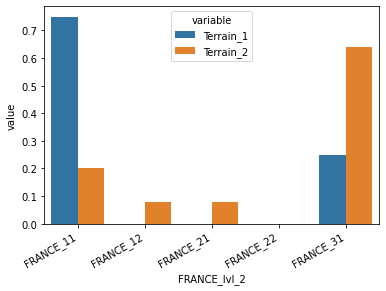

In [566]:
ax = sns.barplot(data=tab_donnees_g, x="FRANCE_lvl_2", y="value", hue='variable')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
ax.set_xticklabels
_=plt.show()

### Top clusters vs terrains

In [344]:
cross.idxmax(axis=1)

FRANCE_lvl_3
FRANCE_111                 (Nappe captive, Sédimentaire, Craie)
FRANCE_112            (Nappe libre, Sédimentaire, Micaschistes)
FRANCE_121    (Nappe captive, Sédimentaire, Calcaires, marne...
FRANCE_122         (Parties libres et captives, Poreux, Sables)
FRANCE_211    (Nappe captive, Matricielle / karstique, Argiles)
FRANCE_212                        (Nappe libre, Poreux, Sables)
FRANCE_221    (Parties libres et captives, Matricielle / fis...
FRANCE_222              (Nappe libre, Poreux, Schistes et grès)
FRANCE_311       (Nappe captive, Matricielle / karstique, Grès)
FRANCE_312                    (Nappe libre, Karstique, Argiles)
FRANCE_313    (Alternativement libre puis captive, Poreux, C...
dtype: object

In [345]:
top_cluster = pd.DataFrame(cross.idxmax(axis=0), columns=["cluster"]).reset_index()
top_cluster

,EtatEH,MilieuEH,DESCR,cluster
0,Alternativement libre puis captive,Karstique / fissures,"Calcaires, marnes et gypse",FRANCE_311
1,Alternativement libre puis captive,Poreux,"Calcaires, marnes et gypse",FRANCE_313
2,Nappe captive,Karstique / fissures,Argiles,FRANCE_111
3,Nappe captive,Karstique / fissures,"Calcaires, marnes et gypse",FRANCE_111
4,Nappe captive,Karstique / fissures,Sables,FRANCE_211
...,...,...,...,...
83,Parties libres et captives,Poreux,Schistes et grès,FRANCE_311
84,Parties libres et captives,Sédimentaire,Argiles,FRANCE_111
85,Parties libres et captives,Sédimentaire,"Calcaires, marnes et gypse",FRANCE_312
86,Parties libres et captives,Sédimentaire,Craie,FRANCE_112


In [346]:
filt_EtatEH = ["Nappe captive", "Parties libres et captives"]
filt_MilieuEH = ["Poreux", "Sédimentaire"]
filt_DESCR = ["Argiles", "Sables"]
cluster_level = "FRANCE_lvl_3"


In [277]:
def f_cluster_terrain (df_data_piezo, cluster_level, filt_EtatEH, filt_MilieuEH, filt_DESCR) :
    cross_df = pd.crosstab(df_data_piezo[cluster_level], columns=[df_data_piezo["EtatEH"],
                                                                    df_data_piezo["MilieuEH"],
                                                                    df_data_piezo["DESCR"]],
                                                    normalize=True)
    # Filtrage
    result_df = pd.DataFrame(cross_df.idxmax(axis=0), columns=["cluster"]).reset_index()
    result_df = result_df.loc[result_df["EtatEH"].isin(filt_EtatEH) & result_df["MilieuEH"].isin(filt_MilieuEH) & result_df["DESCR"].isin(filt_DESCR)]
    return result_df

In [278]:
f_cluster_terrain (data_piezo_data, cluster_level, filt_EtatEH, filt_MilieuEH, filt_DESCR)

,EtatEH,MilieuEH,DESCR,cluster
12,Nappe captive,Poreux,Argiles,FRANCE_211
15,Nappe captive,Poreux,Sables,FRANCE_313
77,Parties libres et captives,Poreux,Argiles,FRANCE_312
82,Parties libres et captives,Poreux,Sables,FRANCE_311
84,Parties libres et captives,Sédimentaire,Argiles,FRANCE_111
87,Parties libres et captives,Sédimentaire,Sables,FRANCE_111


### Heatmap

<AxesSubplot:xlabel='DESCR-MilieuEH-EtatEH-NatureEH', ylabel='FRANCE_lvl_4'>

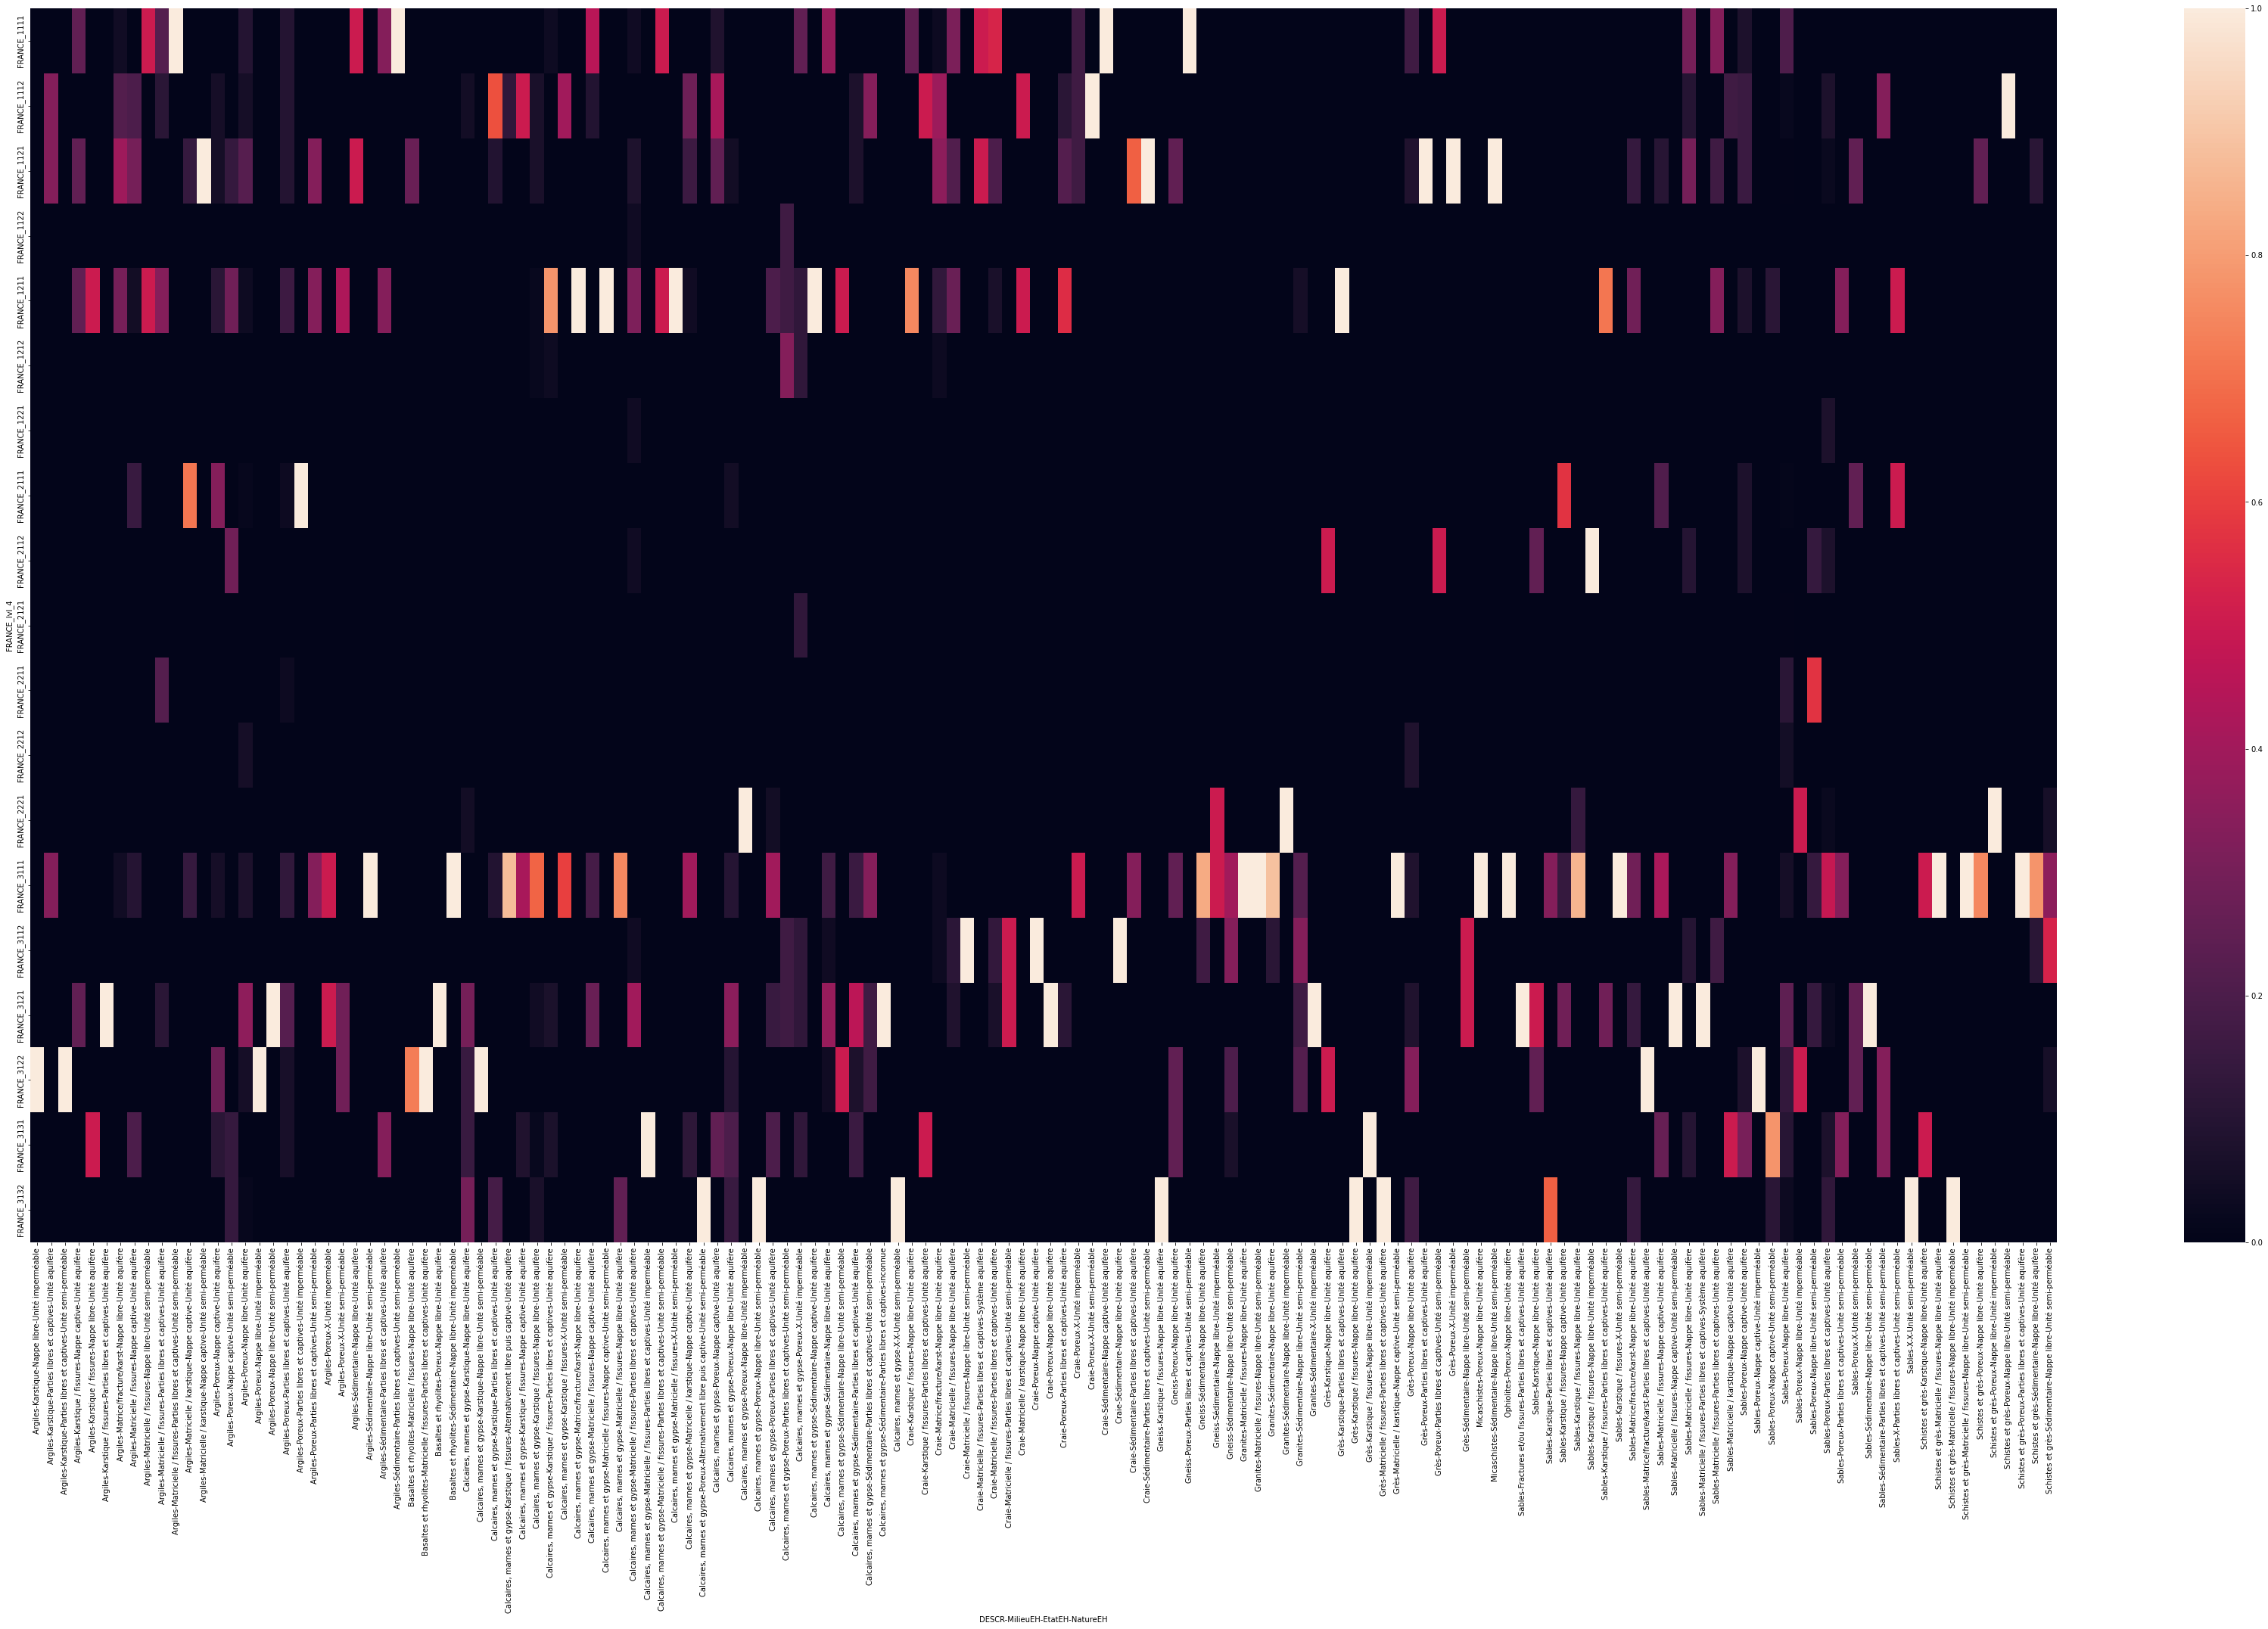

In [214]:
plt.figure(figsize=(60,30))
sns.heatmap(pd.crosstab(data_piezo_data["FRANCE_lvl_4"], columns=[data_piezo_data["DESCR"],
                                                      data_piezo_data["MilieuEH"], 
                                                      data_piezo_data["EtatEH"],
                                                      data_piezo_data["NatureEH"]],
           normalize='columns'))

## Clusteur vs. terrainEH

In [218]:
data_piezo_data.head()

,altitude_station,profondeur_investigation,codes_bdlisa,FRANCE_lvl_1,FRANCE_lvl_2,FRANCE_lvl_3,FRANCE_lvl_4,EtatEH,NatureEH,MilieuEH,ThemeEH,DESCR,TYPE
code_bss,,,,,,,,,,,,,
03423X0056_100,174.0,10.7,221AA15,FRANCE_3,FRANCE_31,FRANCE_312,FRANCE_3121,Nappe libre,Unité aquifère,Poreux,Alluvial,Argiles,Roches Sédimentaires
06216X0228_P30-10,237.2,8.0,932AR01,FRANCE_3,FRANCE_31,FRANCE_312,FRANCE_3122,Nappe libre,Unité aquifère,Poreux,Alluvial,Sables,Roches Sédimentaires
09145X0057_N210,31.0,14.5,712IA01,FRANCE_3,FRANCE_31,FRANCE_313,FRANCE_3131,Nappe libre,Unité aquifère,Poreux,Alluvial,Sables,Roches Sédimentaires
06932X0178_P10,801.8,48.0,153AA01,FRANCE_3,FRANCE_31,FRANCE_312,FRANCE_3122,Nappe libre,Unité aquifère,Matricielle / fissures,Volcanisme,Basaltes et rhyolites,Roches Magmatiques
06505X0093_PZ10,175.0,19.0,507AD00,FRANCE_3,FRANCE_31,FRANCE_312,FRANCE_3122,Nappe libre,Unité imperméable,Poreux,Sédimentaire,Argiles,Roches Sédimentaires


In [230]:
level = "FRANCE_lvl_3"
pd.crosstab(data_piezo_data[level], data_piezo_data["EtatEH"], normalize="columns")

EtatEH,Alternativement libre puis captive,Nappe captive,Nappe libre,Parties libres et captives,X
FRANCE_lvl_3,,,,,
FRANCE_111,0.111111,0.197802,0.164464,0.160714,0.179487
FRANCE_112,0.000000,0.120879,0.096916,0.089286,0.076923
FRANCE_121,0.000000,0.071429,0.067548,0.228571,0.153846
FRANCE_122,0.000000,0.000000,0.000000,0.014286,0.000000
FRANCE_211,0.000000,0.142857,0.013216,0.028571,0.025641
FRANCE_212,0.000000,0.000000,0.001468,0.000000,0.025641
FRANCE_221,0.000000,0.000000,0.052863,0.010714,0.000000
FRANCE_222,0.000000,0.000000,0.013216,0.007143,0.000000
FRANCE_311,0.777778,0.186813,0.261380,0.175000,0.230769


In [232]:
level = "FRANCE_lvl_3"
pd.crosstab(data_piezo_data[level], data_piezo_data["NatureEH"], normalize="index")

NatureEH,Système aquifère,Unité aquifère,Unité imperméable,Unité semi-perméable,inconnue
FRANCE_lvl_3,,,,,
FRANCE_111,0.004975,0.910448,0.019900,0.064677,0.000000
FRANCE_112,0.008621,0.913793,0.017241,0.060345,0.000000
FRANCE_121,0.000000,0.844961,0.015504,0.139535,0.000000
FRANCE_122,0.000000,1.000000,0.000000,0.000000,0.000000
FRANCE_211,0.000000,0.818182,0.045455,0.136364,0.000000
FRANCE_212,0.000000,0.500000,0.500000,0.000000,0.000000
FRANCE_221,0.000000,0.897436,0.000000,0.102564,0.000000
FRANCE_222,0.000000,0.454545,0.454545,0.090909,0.000000
FRANCE_311,0.000000,0.779783,0.025271,0.194946,0.000000


In [233]:
level = "FRANCE_lvl_3"
pd.crosstab(data_piezo_data[level], data_piezo_data["MilieuEH"], normalize="columns")

MilieuEH,Fractures et/ou fissures,Karstique,Karstique / fissures,Matrice/fracture/karst,Matricielle / fissures,Matricielle / karstique,Poreux,Sédimentaire,X
FRANCE_lvl_3,,,,,,,,,
FRANCE_111,0.0,0.183673,0.116788,0.301587,0.235808,0.214286,0.154,0.102410,0.00
FRANCE_112,0.0,0.040816,0.029197,0.333333,0.161572,0.142857,0.076,0.048193,0.00
FRANCE_121,0.0,0.020408,0.248175,0.238095,0.165939,0.047619,0.064,0.036145,0.25
FRANCE_122,0.0,0.000000,0.000000,0.000000,0.004367,0.000000,0.006,0.000000,0.00
FRANCE_211,0.0,0.040816,0.036496,0.000000,0.039301,0.119048,0.044,0.000000,0.25
FRANCE_212,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.004,0.000000,0.00
FRANCE_221,0.0,0.000000,0.000000,0.000000,0.008734,0.000000,0.074,0.000000,0.00
FRANCE_222,0.0,0.020408,0.007299,0.000000,0.000000,0.000000,0.012,0.018072,0.00
FRANCE_311,0.0,0.081633,0.379562,0.079365,0.179039,0.333333,0.140,0.548193,0.00


In [292]:
data_piezo_data.head()

,altitude_station,profondeur_investigation,codes_bdlisa,FRANCE_lvl_1,FRANCE_lvl_2,FRANCE_lvl_3,FRANCE_lvl_4,EtatEH,NatureEH,MilieuEH,ThemeEH,DESCR,TYPE
code_bss,,,,,,,,,,,,,
03423X0056_100,174.0,10.7,221AA15,FRANCE_3,FRANCE_31,FRANCE_312,FRANCE_3121,Nappe libre,Unité aquifère,Poreux,Alluvial,Argiles,Roches Sédimentaires
06216X0228_P30-10,237.2,8.0,932AR01,FRANCE_3,FRANCE_31,FRANCE_312,FRANCE_3122,Nappe libre,Unité aquifère,Poreux,Alluvial,Sables,Roches Sédimentaires
09145X0057_N210,31.0,14.5,712IA01,FRANCE_3,FRANCE_31,FRANCE_313,FRANCE_3131,Nappe libre,Unité aquifère,Poreux,Alluvial,Sables,Roches Sédimentaires
06932X0178_P10,801.8,48.0,153AA01,FRANCE_3,FRANCE_31,FRANCE_312,FRANCE_3122,Nappe libre,Unité aquifère,Matricielle / fissures,Volcanisme,Basaltes et rhyolites,Roches Magmatiques
06505X0093_PZ10,175.0,19.0,507AD00,FRANCE_3,FRANCE_31,FRANCE_312,FRANCE_3122,Nappe libre,Unité imperméable,Poreux,Sédimentaire,Argiles,Roches Sédimentaires


In [296]:
test = data_piezo_data[["FRANCE_lvl_3","MilieuEH" ]]
test

,FRANCE_lvl_3,MilieuEH
code_bss,,
03423X0056_100,FRANCE_312,Poreux
06216X0228_P30-10,FRANCE_312,Poreux
09145X0057_N210,FRANCE_313,Poreux
06932X0178_P10,FRANCE_312,Matricielle / fissures
06505X0093_PZ10,FRANCE_312,Poreux
...,...,...
03162X0049_PZ,FRANCE_311,Sédimentaire
03834X0049_PZ,FRANCE_311,Sédimentaire
04231X0089_PZ,FRANCE_112,Sédimentaire


<AxesSubplot:>

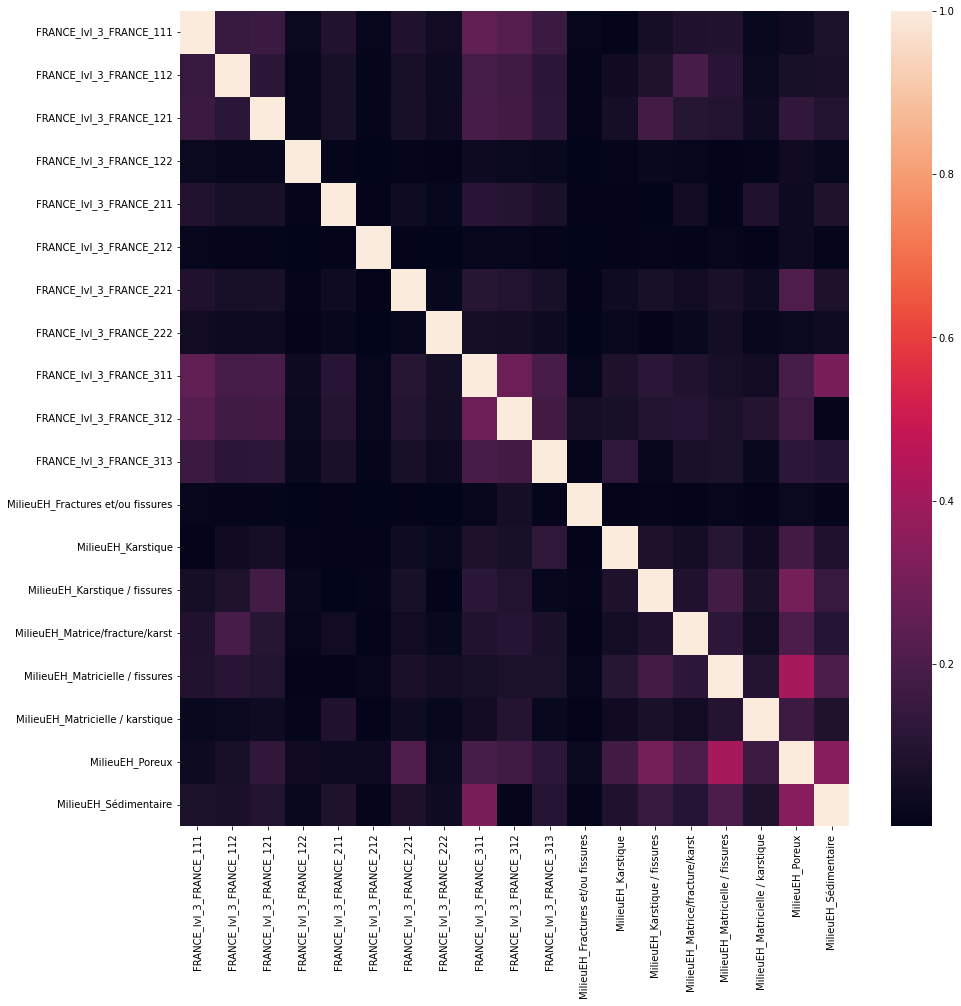

In [297]:
plt.figure(figsize=(15,15))
sns.heatmap(abs(pd.get_dummies(test).corr()))

In [325]:
pd.DataFrame(data_piezo_data.groupby(["EtatEH", "DESCR", "FRANCE_lvl_3"])["FRANCE_lvl_3", "EtatEH", "DESCR"].value_counts())

C:\Users\daranlot\AppData\Local\Temp\ipykernel_12508\3544031242.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



0
EtatEH                             DESCR                      FRANCE_lvl_3    
Alternativement libre puis captive Calcaires, marnes et gypse FRANCE_111     1
                                                              FRANCE_311     7
                                                              FRANCE_313     1
Nappe captive                      Argiles                    FRANCE_111     6
                                                              FRANCE_112    11
...                                                                         ..
Parties libres et captives         Sables                     FRANCE_222     1
                                                              FRANCE_311    22
                                                              FRANCE_312     7
                                                              FRANCE_313    12
                                   Schistes et grès           FRANCE_311     2

[125 rows x 1 columns]